In [107]:
# --- Baseline Cell and Scaling Parameters ---
# Reference: 18650 cell
cell_voltage = 3.6  # V
cell_mass = 0.045   # kg
cell_specific_heat = 1100  # J/(kg·K)
cell_resistance = 0.015    # Ohm
cells_per_zone = 1       # Number of cells per zone (adjustable)

# --- Simulation-wide Parameters ---
num_zones = 1  # Change to 12 for full pack
# Do NOT set pack_voltage, heat_capacity, r_internal here!
# These will be set by the scaling cell below.

# --- Cooling and Conduction Scaling ---
desired_Q_at_10K = 2000.0  # W at ΔT=10K for full pack
UA_total_baseline = desired_Q_at_10K / 10.0  # 200 W/K total
UA0 = None  # Will be set after scaling
k_lat = None  # Will be set after scaling

print(f"[Config] num_zones: {num_zones}, cells_per_zone: {cells_per_zone}")

[Config] num_zones: 1, cells_per_zone: 1


# Battery Cooling Simulation from Real Drive Cycle Data
This notebook simulates realistic battery pack cooling using real-world drive cycles stored in a folder. It uses liquid cooling logic with per-zone thermal dynamics and shared pump modeling.

In [108]:
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, savgol_filter
from scipy.interpolate import RegularGridInterpolator
import os
from scipy.integrate import solve_ivp
import sys
import pybamm
try:
    from CoolProp.CoolProp import PropsSI
    HAVE_CP = True
except Exception:
    HAVE_CP = False


In [109]:
force_rebuild_core = True         # ⬅️ Set True to force re-concatenation
core_path = "/home/keshav/Documents/reserch_code/core.csv"
checkpoint_dir = "/home/keshav/Documents/reserch_code/checkpoints"
drive_cycle_folder = "/home/keshav/Documents"

os.makedirs("data", exist_ok=True)
os.makedirs(checkpoint_dir, exist_ok=True)

In [110]:
def noise(temps, scale=0.15, seed=42):
    """
    Adds low-frequency noise to simulate realistic battery cell variation.
    Inputs:
        temps: np.ndarray (time × zones)
        scale: noise magnitude (°C)
        seed: random seed for reproducibility
    Returns:
        temps + gen_ai variation (same shape)
    """
    np.random.seed(seed)
    raw_noise = np.random.normal(0, 1, temps.shape)
    b, a = butter(2, 0.05)  # Low-pass filter
    smooth_noise = filtfilt(b, a, raw_noise, axis=0)
    return temps + scale * smooth_noise


In [111]:
# --- Config ---
force_rebuild_core = True   # toggle this when you want to rebuild
core_path = "core.csv"       # where the preprocessed drive cycle data is stored
drive_cycle_folder = "/home/keshav/Documents"  # folder with .txt files

# --- Build or load ---
if not os.path.exists(core_path) or force_rebuild_core:
    print("🔄 Building core.csv from drive_cycles...")

    dfs = []
    all_txts = sorted(f for f in os.listdir(drive_cycle_folder) if f.endswith(".txt"))

    for file in all_txts:
        path = os.path.join(drive_cycle_folder, file)

        # Try multiple encodings
        for enc in ["utf-16", "ISO-8859-1", "utf-8"]:
            try:
                df = pd.read_csv(
                    path,
                    sep="\t",
                    skiprows=1,
                    names=["Time", "Speed"],
                    encoding=enc,
                    engine="python",
                )
                break
            except Exception as e:
                df = None
        if df is None:
            print(f"⚠️ Skipping {file} (could not parse with any encoding)")
            continue

        # Cleanup
        df = df.dropna()
        df["File"] = file
        dfs.append(df)

    if not dfs:
        raise RuntimeError("❌ No valid drive cycle files found!")

    # Combine & compute derived fields
    drive_df = pd.concat(dfs, ignore_index=True)
    drive_df["Speed"] = pd.to_numeric(drive_df["Speed"], errors="coerce").fillna(0)
    drive_df["Speed_mps"] = drive_df["Speed"] * 0.44704
    drive_df["Acceleration"] = drive_df["Speed_mps"].diff().fillna(0)
    # simplified vehicle mass assumption (1600 kg)
    drive_df["Power_W"] = (1600 * drive_df["Speed_mps"] * drive_df["Acceleration"]).clip(lower=0)
    drive_df["CumulativeTime"] = np.arange(len(drive_df))

    # Save core.csv
    drive_df.to_csv(core_path, index=False)
    print(f"✅ core.csv saved with {len(drive_df)} rows")

else:
    drive_df = pd.read_csv(core_path)
    print(f"📄 core.csv loaded with {len(drive_df)} rows")

# --- Inputs for battery model ---
time = drive_df["CumulativeTime"].values
power_input = drive_df["Power_W"].values
timesteps = len(time)

print(f"⏱ timesteps = {timesteps}, total duration ~{timesteps/60:.1f} minutes")


🔄 Building core.csv from drive_cycles...
✅ core.csv saved with 7500 rows
⏱ timesteps = 7500, total duration ~125.0 minutes


In [112]:
# --- Reload core or extended drive_df after restart ---
use_generated = False  # True = use core_plus_generated.csv
fraction = 1       # 1 = 100% of rows, 0.01 = 1% of rows

core_path = "/home/keshav/Documents/reserch_code/core.csv"
generated_path = "/home/keshav/Documents/reserch_code/core_plus_generated.csv"

# Load the appropriate file
drive_df = pd.read_csv(generated_path if use_generated else core_path)

# Keep only the requested fraction in chronological order
if fraction < 1:
    num_rows = int(len(drive_df) * fraction)
    drive_df = drive_df.iloc[:num_rows].reset_index(drop=True)

print(f"📄 Loaded {len(drive_df):,} rows ({fraction*100:.2f}% of dataset)")

# Vehicle parameters
m = 1800  # kg (mass of car)
g = 9.81  # gravity
Cd = 0.28  # drag coefficient
A = 2.3  # frontal area (m²)
Crr = 0.01  # rolling resistance
rho = 1.225  # air density (kg/m³)
eff = 0.9  # drivetrain efficiency
dt = 1  # timestep (seconds)

# Update derived fields (just in case)
drive_df["Speed"] = pd.to_numeric(drive_df["Speed"], errors="coerce").fillna(0)
drive_df["Speed_mps"] = drive_df["Speed"] * 0.44704

# Use a slightly larger window for more robust smoothing. Use this smoothed value for ALL subsequent physics.
smooth_speed = drive_df["Speed_mps"].rolling(5, center=True).mean().fillna(method="bfill").fillna(method="ffill")
drive_df["Acceleration"] = smooth_speed.diff().fillna(0) / dt

# --- Physics-based forces using SMOOTHED speed ---
F_aero = 0.5 * rho * Cd * A * smooth_speed**2
F_roll = m * g * (Crr + 0.0005 * smooth_speed)
F_inertia = m * drive_df["Acceleration"]  # This already uses smoothed data

F_total = F_aero + F_roll + F_inertia

# --- Power in W, also using SMOOTHED speed ---
drive_df["Power_W"] = ((F_total * smooth_speed) / eff).clip(lower=0)


# Time & power for simulation
time = np.arange(len(drive_df))
power_input = drive_df["Power_W"].values
timesteps = len(time)

print(f"✅ Reloaded {'core_plus_generated' if use_generated else 'core'} data with {timesteps} steps into drive_df")


📄 Loaded 7,500 rows (100.00% of dataset)
✅ Reloaded core data with 7500 steps into drive_df


/tmp/ipykernel_14961/2256759151.py:33: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  smooth_speed = drive_df["Speed_mps"].rolling(5, center=True).mean().fillna(method="bfill").fillna(method="ffill")


In [113]:
print(f"Max accel: {drive_df['Acceleration'].max():.2f} m/s²")
print(f"Max power: {drive_df['Power_W'].max():,.0f} W")

Max accel: 0.16 m/s²
Max power: 1,578 W


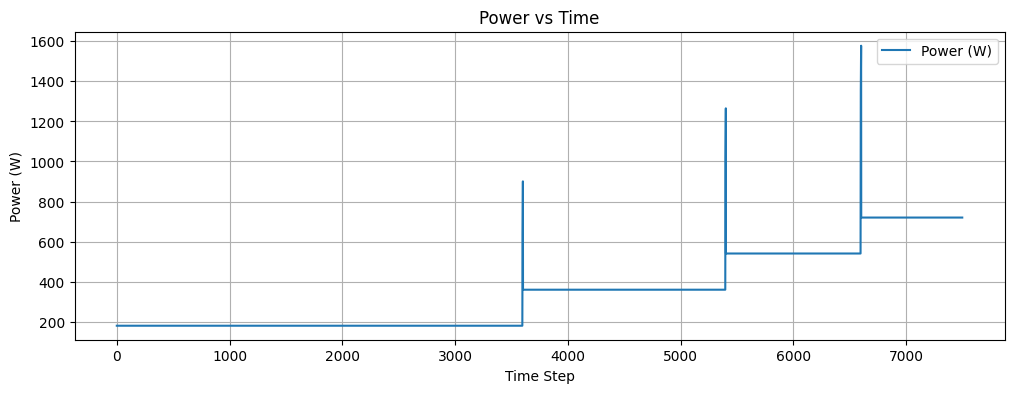

In [114]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4))
plt.plot(drive_df["Power_W"], label="Power (W)")
plt.title("Power vs Time")
plt.xlabel("Time Step")
plt.ylabel("Power (W)")
plt.grid()
plt.legend()
plt.show()

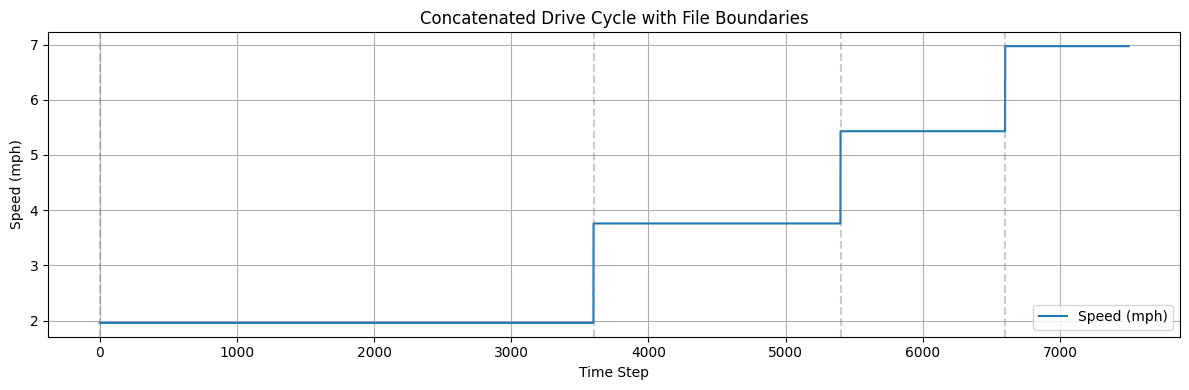

In [115]:
plt.figure(figsize=(12, 4))
plt.plot(drive_df["CumulativeTime"], drive_df["Speed"], label="Speed (mph)")

# Identify file boundaries and mark them
boundaries = drive_df["File"].ne(drive_df["File"].shift()).cumsum()
boundary_indices = drive_df.groupby(boundaries).head(1).index

for i in boundary_indices:
    plt.axvline(i, color='gray', linestyle='--', alpha=0.4)

plt.title("Concatenated Drive Cycle with File Boundaries")
plt.xlabel("Time Step")
plt.ylabel("Speed (mph)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [116]:
# --- Core thermal parameters ---
num_zones = 1
initial_temp = 35.0  # starting temperature
optimum_temp_range = (25.0, 35.0)
cooling_threshold = 30.0

# --- Thermal & Pump System Parameters ---
a_pump = 0.005  # Adjusted to scale power usage realistically
b_pump = 0.1    # Linear term for base flow

# --- System-wide physical constants ---
cooling_time_constant = 3  # seconds for coolant effect to stabilize
heating_delay_steps = 3    # delay steps for power-to-temp rise

# --- Per-zone physical properties (based on SoH, contact, etc.) ---

# Initial SoC: slightly varied
initial_soc = np.clip(np.random.normal(0.5, 0.05, num_zones), 0.3, 0.7)

# State of Health (SoH): 1 = new, <1 = aged
soh = np.clip(np.random.normal(0.95, 0.03, num_zones), 0.8, 1.0)

# Internal resistance (higher = more heat)
base_r_internal = 0.01  # ohms
r_internal = base_r_internal / soh + np.random.normal(0, 0.001, num_zones)
r_internal = np.clip(r_internal, 0.005, 0.03)  # Prevent unrealistic high resistance

# Heat capacity (thermal mass)
cell_mode = True  # toggle this

if cell_mode:
    # ~100 J/K per cell
    heat_capacity = np.clip(np.random.normal(100.0, 20.0, num_zones), 70.0, 150.0)
else:
    # pack-scaled capacity (old)
    heat_capacity = np.clip(np.random.normal(14.0, 1.0, num_zones), 10.0, 18.0) * 1000


# Cooling efficiency: higher at edges
edge_factor = np.abs(np.linspace(-1, 1, num_zones))
cooling_efficiency = 1 + 0.3 * edge_factor + np.random.normal(0, 0.05, num_zones)

# Thermal noise: time & space correlated
def correlated_noise(shape, scale=0.02):
    base = np.random.normal(0, scale, shape)
    for t in range(1, shape[0]):
        base[t] = 0.6 * base[t] + 0.3 * base[t - 1] + 0.1 * np.roll(base[t], 1)
    return base

thermal_noise = correlated_noise((timesteps, num_zones), scale=0.02)

# Lateral conduction (more at edges)
left_bias_conductance = 0.03 + 0.03 * np.abs(np.linspace(-1, 1, num_zones - 1))

# --- System states ---
temps = np.full((timesteps, num_zones), initial_temp)
valves = np.zeros((timesteps, num_zones))
coolant_flow = np.zeros((timesteps, num_zones))
pump_power = np.zeros(timesteps)

# --- Delay buffer for heating effect (using exponential smoothing) ---
alpha = 0.2  # smoothing factor (lower = smoother)
delayed_power = np.zeros(timesteps)
delayed_power[0] = power_input[0]  # initialize with first value

for i in range(1, timesteps):
    delayed_power[i] = alpha * power_input[i] + (1 - alpha) * delayed_power[i - 1]

# # --- Cap power input to realistic EV limits ---
# max_power_kw = 200  # still a fair cap
# delayed_power = np.clip(delayed_power, 0, max_power_kw)

# --- SOC tracking ---
capacity_Ah = 80.0   # example pack capacity
soc = np.zeros(timesteps)
soc[0] = 0.6         # start at 60% SOC

for k in range(1, timesteps):
    # Current in A (discharge positive, regen negative)
    current = delayed_power[k-1] / 360.0   # divide by pack voltage (360 V)
    soc[k] = soc[k-1] - (current * dt) / (capacity_Ah * 3600.0)
    soc[k] = np.clip(soc[k], 0.01, 0.99)


print("🔍 DEBUG OUTPUT")

# Check delayed power distribution
print(f"▶ Delayed power (first 40): {delayed_power[:40]}")
print(f"   Min: {delayed_power.min():.2f} kW | Max: {delayed_power.max():.2f} kW")

# Print internal resistance
print(f"▶ Internal resistance range: {r_internal.min():.5f} Ω to {r_internal.max():.5f} Ω")

# Print heat capacity
print(f"▶ Heat capacity range: {heat_capacity.min():.2f} to {heat_capacity.max():.2f} kJ/°C")

# Cooling efficiency distribution
print(f"▶ Cooling efficiency (mean ± std): {np.mean(cooling_efficiency):.2f} ± {np.std(cooling_efficiency):.2f}")

# First few values of noise (just to sanity-check magnitude)
print(f"▶ Thermal noise sample (first timestep): {thermal_noise[0, :40]}")


🔍 DEBUG OUTPUT
▶ Delayed power (first 40): [179.73631487 179.73631487 179.73631487 179.73631487 179.73631487
 179.73631487 179.73631487 179.73631487 179.73631487 179.73631487
 179.73631487 179.73631487 179.73631487 179.73631487 179.73631487
 179.73631487 179.73631487 179.73631487 179.73631487 179.73631487
 179.73631487 179.73631487 179.73631487 179.73631487 179.73631487
 179.73631487 179.73631487 179.73631487 179.73631487 179.73631487
 179.73631487 179.73631487 179.73631487 179.73631487 179.73631487
 179.73631487 179.73631487 179.73631487 179.73631487 179.73631487]
   Min: 179.74 kW | Max: 1159.72 kW
▶ Internal resistance range: 0.01057 Ω to 0.01057 Ω
▶ Heat capacity range: 94.83 to 94.83 kJ/°C
▶ Cooling efficiency (mean ± std): 1.27 ± 0.00
▶ Thermal noise sample (first timestep): [-0.02729058]


In [117]:
# --- Robust Universal Scaling for Single Cell and Pack ---
# Set num_zones and cells_per_zone before this cell.

# Compute total number of cells
single_cell_mode = (num_zones == 1 and cells_per_zone == 1)
total_pack_cells = num_zones * cells_per_zone

# Always use correct voltage, heat capacity, and resistance
if single_cell_mode:
    pack_voltage = cell_voltage
    heat_capacity = np.array([cell_specific_heat * cell_mass])
    r_internal = np.array([cell_resistance])
    # Scale power input if drive cycle is for a pack
    if power_input.max() > 20:
        power_input = power_input / total_pack_cells
        delayed_power = delayed_power / total_pack_cells
else:
    pack_voltage = cell_voltage * cells_per_zone
    heat_capacity = np.full(num_zones, cell_specific_heat * cell_mass * cells_per_zone)
    r_internal = np.full(num_zones, cell_resistance * cells_per_zone)

print(f"[Scaling] num_zones: {num_zones}, cells_per_zone: {cells_per_zone}, total_pack_cells: {total_pack_cells}")
print(f"[Scaling] pack_voltage: {pack_voltage} V")
print(f"[Scaling] heat_capacity: {heat_capacity}")
print(f"[Scaling] r_internal: {r_internal}")
print(f"[Scaling] power_input (first 5): {power_input[:5]}")

[Scaling] num_zones: 1, cells_per_zone: 1, total_pack_cells: 1
[Scaling] pack_voltage: 3.6 V
[Scaling] heat_capacity: [49.5]
[Scaling] r_internal: [0.015]
[Scaling] power_input (first 5): [179.73631487 179.73631487 179.73631487 179.73631487 179.73631487]


In [118]:
# Add this to your imports in Cell 2
from scipy.integrate import solve_ivp

adiabatic_mode = True   # True = no cooling (validate vs paper)

# --- PID Controller Class ---
class PIDController:
    def __init__(self, Kp, Ki, Kd, setpoint, output_limits=(0, 100)):
        self.Kp = Kp
        self.Ki = Ki
        self.Kd = Kd
        self.setpoint = setpoint
        self.output_limits = output_limits
        self.integral = 0
        self.prev_error = 0

    def reset(self):
        self.integral = 0
        self.prev_error = 0

    def __call__(self, measurement, dt):
        error = self.setpoint - measurement
        self.integral += error * dt
        derivative = (error - self.prev_error) / dt if dt > 0 else 0
        output = self.Kp * error + self.Ki * self.integral + self.Kd * derivative
        output = np.clip(output, *self.output_limits)
        self.prev_error = error
        return output

# --- [CORRECTED CODE BLOCK v2 - Replaces Cell 11] ---


# 1. Define the function that describes the system's derivatives (d(temp)/dt, d(flow)/dt)
def battery_ode(t, y, power_profile, r_internal, heat_capacity, UA0, k_lat,
                max_total_flow, T_coolant, pid_controllers, dt):
    
    current_temps = y[:num_zones]
    current_flows = y[num_zones:]

    time_idx = min(int(t), len(power_profile) - 1)
    power = power_profile[time_idx]
    
    V_pack = 3.600
    current = power / V_pack
    Q_total = (current ** 2) * np.sum(r_internal) # Total pack Joule heat
    heat_input = Q_total * (r_internal / np.sum(r_internal)) # Distribute across zones proportional to r_internal


    # raw_valves: 0..100 (% from PID)
    raw_valves = np.zeros(num_zones)
    for z in range(num_zones):
        raw_valves[z] = pid_controllers[z](current_temps[z], dt)

    # Convert PID % to requested flow in L/min (each zone’s max = total/n_zones)
    requested_flow = (raw_valves / 100.0) * (max_total_flow / num_zones)

    # Scale down if pump capacity exceeded
    total_requested_flow = np.sum(requested_flow)
    if total_requested_flow > max_total_flow and total_requested_flow > 0:
        requested_flow *= max_total_flow / total_requested_flow

    # Use target_valves to stay consistent with rest of code
    target_valves = requested_flow


    d_temps_dt = np.zeros(num_zones)
    d_flows_dt = np.zeros(num_zones)

    for z in range(num_zones):
        T = current_temps[z]
        T_left = current_temps[z - 1] if z > 0 else T
        T_right = current_temps[z + 1] if z < num_zones - 1 else T

        # --- lateral conduction with neighbors ---
        left_cond = k_lat[z-1] * (T_left - T) if z > 0 else 0
        right_cond = k_lat[z] * (T_right - T) if z < num_zones - 1 else 0

        flow_fraction = current_flows[z] / (max_total_flow / num_zones) if (max_total_flow > 0) else 0.0
        flow_fraction = np.clip(flow_fraction, 0.0, 1.0)

        UA_z = UA0[z] * (1.0 + alpha_flow * flow_fraction)
        cooling_effect = UA_z * (T - T_coolant) if not adiabatic_mode else 0.0

        d_temps_dt[z] = (
            heat_input[z]
            + left_cond + right_cond
            - cooling_effect
            + thermal_noise[time_idx, z]
        ) / heat_capacity[z]

    d_flows_dt = (target_valves - current_flows) / cooling_time_constant

    print(">>> UA0 per zone (W/K):", UA0[0])
    # print(">>> max_total_flow (L/min):", max_total_flow)
    # print(">>> Q_max (m3/s):", Q_max_m3s)
    # print(">>> pump_power_max (W):", pump_power_max)
    # # check predicted cooling at ΔT=10K baseline & full flow:
    # UA_total_baseline = UA0.sum()
    # UA_total_fullflow = (UA0 * (1.0 + alpha_flow)).sum()
    # print(">>> Predicted cooling at ΔT=10K baseline (W):", UA_total_baseline*10.0)
    # print(">>> Predicted cooling at ΔT=10K full flow (W):", UA_total_fullflow*10.0)

    
    return np.concatenate([d_temps_dt, d_flows_dt])

# 2. Set up initial conditions and simulation parameters
initial_temps = np.full(num_zones, initial_temp)
initial_flows = np.zeros(num_zones)
y0 = np.concatenate([initial_temps, initial_flows])

# --- Fixed convection + conduction parameters ---
if adiabatic_mode:
    UA0 = np.zeros(num_zones)   # no convection
    max_total_flow = 0.0        # no pump/flow
    alpha_flow = 0.0             # no flow effect
else:
    desired_Q_at_10K = 2000.0
    UA_total_baseline = desired_Q_at_10K / 10.0   # 200 W/K total
    UA0 = np.full(num_zones, UA_total_baseline / num_zones)
    max_total_flow = 120.0      # pump flow capacity
    alpha_flow = 1.0  # doubles UA at full flow

k_lat = np.full(num_zones - 1, 8.0)  # W/K conduction between neighbors


# --- (!!!) DEFINE THE VARIABLES HERE (!!!) ---
#max_total_flow = 120.0
T_coolant = 20.0  # Coolant inlet temperature (°C)
h_convection = 0.05 # Convective heat transfer coefficient

# --- PID setup ---
Kp, Ki, Kd = 8.0, 0.1, 2.0
setpoint = optimum_temp_range[1]  # Target upper bound
pid_controllers = [PIDController(Kp, Ki, Kd, setpoint) for _ in range(num_zones)]

t_span = [0, timesteps - 1]
t_eval = time
dt = 1  # seconds per step

# DIAGNOSTIC SNIPPET — paste before solve_ivp
V_pack = 3.600
dt = 1.0
# Use the delayed_power you already compute (W)
power_ts = delayed_power  # W
I_ts = power_ts / V_pack  # A

R_pack = np.sum(r_internal)   # ohm (current code maintains r_internal array)
C_total = np.sum(heat_capacity)  # J/K

joule_energy = np.sum((I_ts**2) * R_pack) * dt   # total Joule energy over run in J
expected_deltaT = joule_energy / C_total         # K

print("=== DIAGNOSTICS ===")
print(f"Num steps: {len(power_ts)}")
print(f"Pack voltage: {V_pack} V")
print(f"R_pack (sum r_internal): {R_pack:.6f} Ω")
print(f"Heat capacity per zone sample: {heat_capacity[:min(5,len(heat_capacity))]}")
print(f"Total heat capacity C_total: {C_total:.1f} J/K")
print(f"Sum(I^2) over time: {np.sum(I_ts**2):.3e} A^2·s")
print(f"Joule energy (I^2 R) total: {joule_energy:.3e} J")
print(f"Expected adiabatic ΔT = Joule_energy / C_total = {expected_deltaT:.3f} K")
print("Peak power (W):", power_ts.max())
print("Peak current (A):", (power_ts.max()/V_pack))
print("===================")


print("⚙️ Running simulation with PID-controlled valves...")

# 3. Call the ODE solver
solution = solve_ivp(
    fun=lambda t, y: battery_ode(
        t, y, delayed_power, r_internal, heat_capacity, UA0, k_lat,
        max_total_flow, T_coolant, pid_controllers, dt),

    t_span=t_span,
    y0=y0,
    t_eval=t_eval,
    method='RK45'
)

print("✅ Simulation complete.")

# 4. Post-process the results
solved_temps = solution.y[:num_zones, :].T
solved_flows = solution.y[num_zones:, :].T

temps = solved_temps
coolant_flow = solved_flows

for t in range(1, timesteps):
    raw_valves = np.zeros(num_zones)
    for z in range(num_zones):
        T = temps[t, z]
        raw_valves[z] = pid_controllers[z](T, dt)
    
    total_requested_flow = np.sum(raw_valves)
    flow_scaling = min(1.0, max_total_flow / total_requested_flow) if total_requested_flow > 0 else 0
    valves[t] = raw_valves * flow_scaling
    
    # total_actual_flow is sum of per-zone L/min (we stored flows as L/min)
    total_flow_LPM = np.sum(valves[t])   # valves[t] now contains flows in L/min
    Q_m3s = total_flow_LPM * 1e-3 / 60.0
    Q_max_m3s = (max_total_flow * 1e-3 / 60.0)

    pump_power_max = 200.0  # W at max_total_flow (choose realistic pump electrical rating)
    if Q_max_m3s > 0:
        pump_power[t] = pump_power_max * (Q_m3s / Q_max_m3s)**2
    else:
        pump_power[t] = 0.0


=== DIAGNOSTICS ===
Num steps: 7500
Pack voltage: 3.6 V
R_pack (sum r_internal): 0.015000 Ω
Heat capacity per zone sample: [49.5]
Total heat capacity C_total: 49.5 J/K
Sum(I^2) over time: 9.067e+07 A^2·s
Joule energy (I^2 R) total: 1.360e+06 J
Expected adiabatic ΔT = Joule_energy / C_total = 27476.496 K
Peak power (W): 1159.7192833408344
Peak current (A): 322.144245372454
⚙️ Running simulation with PID-controlled valves...
>>> UA0 per zone (W/K): 0.0
>>> UA0 per zone (W/K): 0.0
>>> UA0 per zone (W/K): 0.0
>>> UA0 per zone (W/K): 0.0
>>> UA0 per zone (W/K): 0.0
>>> UA0 per zone (W/K): 0.0
>>> UA0 per zone (W/K): 0.0
>>> UA0 per zone (W/K): 0.0
>>> UA0 per zone (W/K): 0.0
>>> UA0 per zone (W/K): 0.0
>>> UA0 per zone (W/K): 0.0
>>> UA0 per zone (W/K): 0.0
>>> UA0 per zone (W/K): 0.0
>>> UA0 per zone (W/K): 0.0
>>> UA0 per zone (W/K): 0.0
>>> UA0 per zone (W/K): 0.0
>>> UA0 per zone (W/K): 0.0
>>> UA0 per zone (W/K): 0.0
>>> UA0 per zone (W/K): 0.0
>>> UA0 per zone (W/K): 0.0
>>> UA0 per z

In [119]:
# === QUICK DIAGNOSTIC ===
print("=== DEBUGGING YOUR SINGLE CELL ===")

# Check your current parameters
print(f"Voltage: {3.6} V (correct for single cell)")
print(f"Heat capacity: {heat_capacity[0]:.1f} J/K")
print(f"Internal resistance: {r_internal[0]:.6f} Ω")

# Test with max power
max_power = delayed_power.max()
max_current = max_power / 3.6
max_heat = max_current**2 * r_internal[0]
temp_rise_per_sec = max_heat / heat_capacity[0]

print(f"\nWith your max power ({max_power:.0f} W):")
print(f"Current: {max_current:.1f} A")
print(f"Heat generation: {max_heat:.2f} W") 
print(f"Temp rise: {temp_rise_per_sec:.3f} K/second")
print(f"Temp rise: {temp_rise_per_sec*60:.1f} K/minute")

if temp_rise_per_sec > 0.5:
    print("❌ PROBLEM: Temperature rise too fast!")
    print("🔧 Need to reduce power or increase heat capacity")
else:
    print("✅ Temperature rise looks reasonable")

def battery_ode(t, y, power_profile, r_internal, heat_capacity, UA0, k_lat,
                max_total_flow, T_coolant, pid_controllers, dt):
    current_temps = y[:num_zones]
    current_flows = y[num_zones:]
    time_idx = min(int(t), len(power_profile) - 1)
    power = power_profile[time_idx]
    # --- Properly scaled pack current and heat per zone ---
    pack_current = power / pack_voltage if pack_voltage > 0 else 0.0
    heat_per_zone = (pack_current ** 2) * r_internal  # array, one per zone
    # PID and flow logic
    raw_valves = np.zeros(num_zones)
    for z in range(num_zones):
        raw_valves[z] = pid_controllers[z](current_temps[z], dt)
    requested_flow = (raw_valves / 100.0) * (max_total_flow / num_zones)
    total_requested_flow = np.sum(requested_flow)
    if total_requested_flow > max_total_flow and total_requested_flow > 0:
        requested_flow *= max_total_flow / total_requested_flow
    target_valves = requested_flow
    d_temps_dt = np.zeros(num_zones)
    d_flows_dt = np.zeros(num_zones)
    for z in range(num_zones):
        T = current_temps[z]
        T_left = current_temps[z - 1] if z > 0 else T
        T_right = current_temps[z + 1] if z < num_zones - 1 else T
        # Lateral conduction (only if num_zones > 1)
        left_cond = k_lat[z-1] * (T_left - T) if z > 0 and num_zones > 1 else 0
        right_cond = k_lat[z] * (T_right - T) if z < num_zones - 1 and num_zones > 1 else 0
        flow_fraction = current_flows[z] / (max_total_flow / num_zones) if (max_total_flow > 0) else 0.0
        flow_fraction = np.clip(flow_fraction, 0.0, 1.0)
        UA_z = UA0[z] * (1.0 + alpha_flow * flow_fraction)
        cooling_effect = UA_z * (T - T_coolant) if not adiabatic_mode else 0.0
        d_temps_dt[z] = (
            heat_per_zone[z]
            + left_cond + right_cond
            - cooling_effect
            + thermal_noise[time_idx, z]
        ) / heat_capacity[z]
    d_flows_dt = (target_valves - current_flows) / cooling_time_constant
    return np.concatenate([d_temps_dt, d_flows_dt])

=== DEBUGGING YOUR SINGLE CELL ===
Voltage: 3.6 V (correct for single cell)
Heat capacity: 49.5 J/K
Internal resistance: 0.015000 Ω

With your max power (1160 W):
Current: 322.1 A
Heat generation: 1556.65 W
Temp rise: 31.448 K/second
Temp rise: 1886.9 K/minute
❌ PROBLEM: Temperature rise too fast!
🔧 Need to reduce power or increase heat capacity


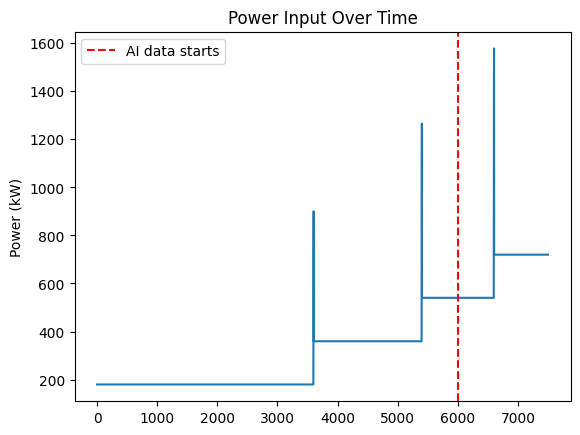

In [120]:
plt.plot(power_input[:10000])
plt.axvline(6000, color='r', linestyle='--', label='AI data starts')
plt.title("Power Input Over Time")
plt.ylabel("Power (kW)")
plt.legend()

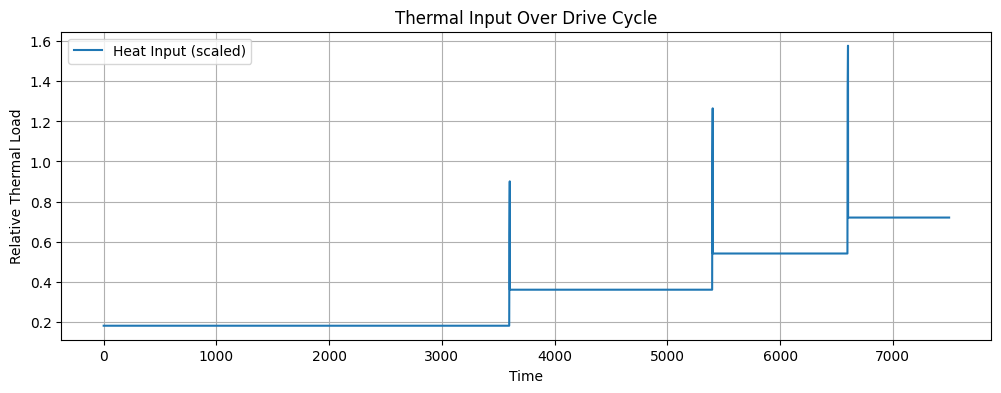

In [121]:
plt.figure(figsize=(12, 4))
heat_regions = power_input * 1e-3  # from simulation
plt.plot(time, heat_regions, label="Heat Input (scaled)")
plt.title("Thermal Input Over Drive Cycle")
plt.xlabel("Time")
plt.ylabel("Relative Thermal Load")
plt.grid(True)
plt.legend()
plt.show()

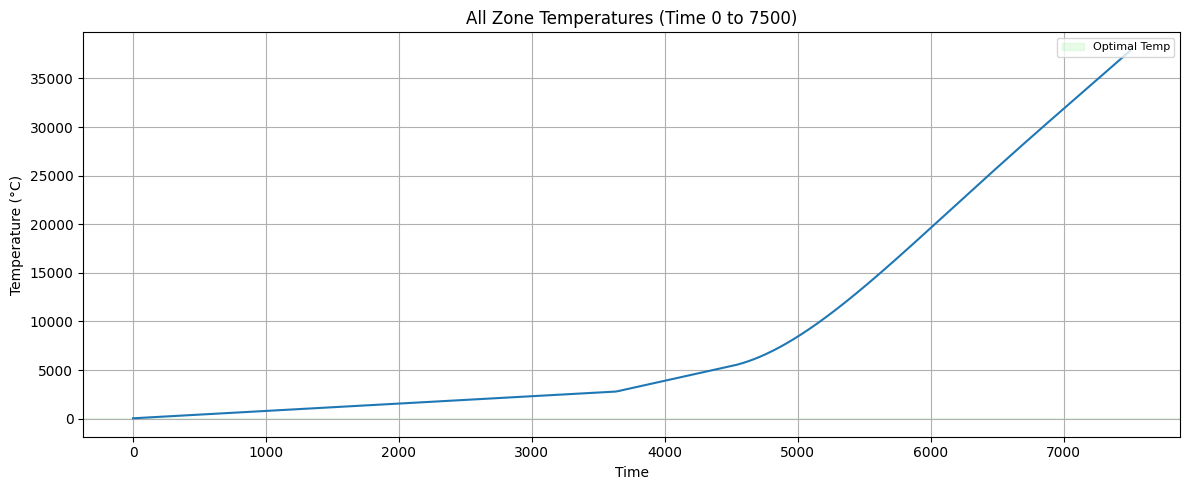

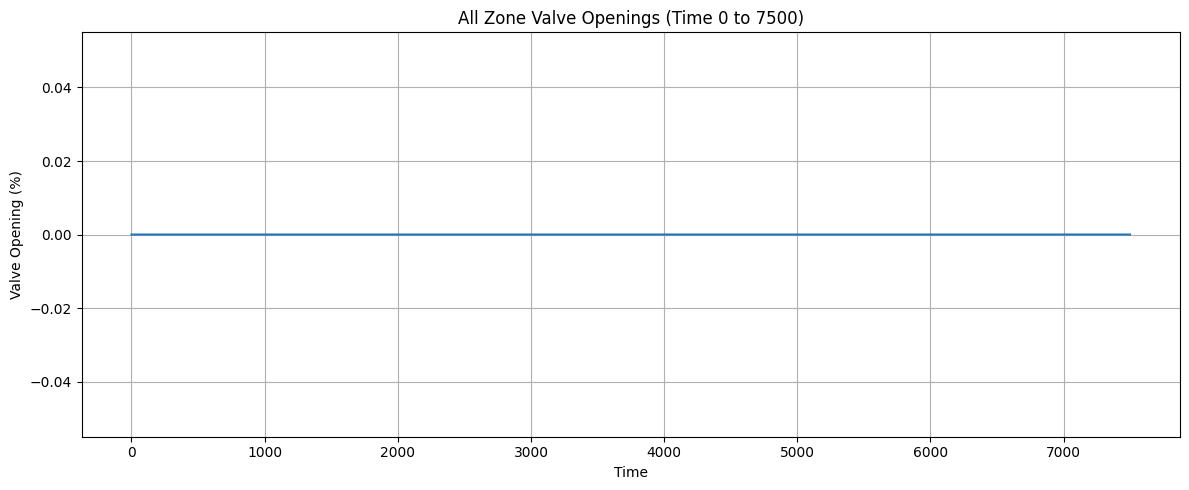

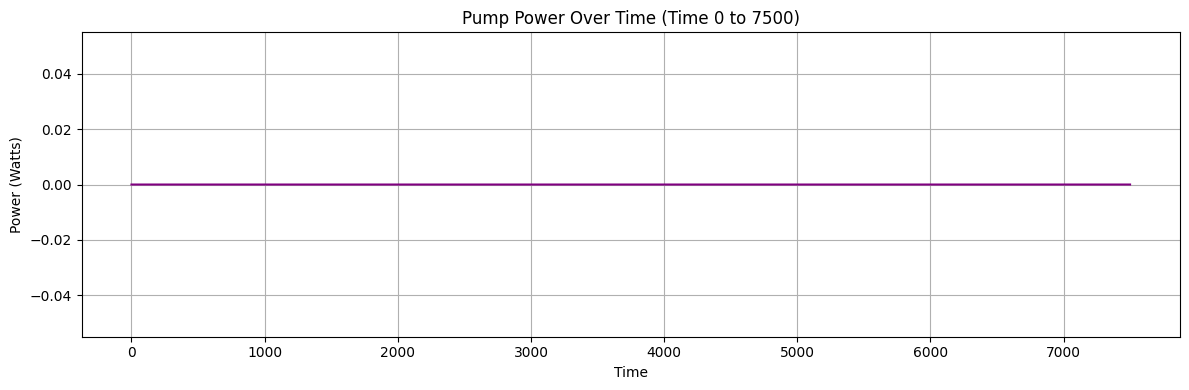

In [122]:
# Time range selection (edit these values as needed)
start_time = 0
end_time = len(time)  # e.g., 0–500 steps, or len(time) for full

# Clamp range to safe bounds
start_time = max(0, start_time)
end_time = min(len(time), end_time)

# Slice the time range
t_range = slice(start_time, end_time)

# 🔥 Plot all zone temperatures
plt.figure(figsize=(12, 5))
plt.plot(time[t_range], temps[t_range, :])
plt.axhspan(30, 35, color='lightgreen', alpha=0.2, label="Optimal Temp")
plt.title(f"All Zone Temperatures (Time {start_time} to {end_time})")
plt.xlabel("Time")
plt.ylabel("Temperature (°C)")
plt.grid(True)
plt.legend(loc="upper right", fontsize=8)
plt.tight_layout()
plt.show()

# 🔧 Plot all valve openings
plt.figure(figsize=(12, 5))
plt.plot(time[t_range], valves[t_range, :])
plt.title(f"All Zone Valve Openings (Time {start_time} to {end_time})")
plt.xlabel("Time")
plt.ylabel("Valve Opening (%)")
plt.grid(True)
plt.tight_layout()
plt.show()

# ⚡ Plot pump power
plt.figure(figsize=(12, 4))
plt.plot(time[t_range], pump_power[t_range], color="purple")
plt.title(f"Pump Power Over Time (Time {start_time} to {end_time})")
plt.xlabel("Time")
plt.ylabel("Power (Watts)")
plt.grid(True)
plt.tight_layout()
plt.show()


In [123]:
df = pd.DataFrame({"Time": time})
for z in range(num_zones):
    df[f"ZoneTemp_{z+1}"] = temps[:, z]
    df[f"ValveOpen_{z+1}"] = valves[:, z]
df.to_csv("/home/keshav/Documents/reserch_code/simulated_battery_cooling.csv", index=False)


In [124]:
def validate_scaling(num_zones_list=[1, 4, 12], cells_per_zone=100, power=1000):
    """
    Check that total heat generated is conserved and scaling is correct for different zone configs.
    """
    print("\n--- Scaling Validation ---")
    for nz in num_zones_list:
        pack_voltage = cell_voltage * cells_per_zone
        zone_resistance = cell_resistance * cells_per_zone
        r_internal = np.full(nz, zone_resistance)
        pack_current = power / pack_voltage if pack_voltage > 0 else 0.0
        heat_per_zone = (pack_current ** 2) * r_internal
        total_heat = np.sum(heat_per_zone)
        print(f"Zones: {nz:2d} | Pack V: {pack_voltage:4.0f} V | Zone R: {zone_resistance:.4f} Ω | Total Heat: {total_heat:.2f} W | Per Zone: {heat_per_zone[0]:.2f} W")
    print("Should see total heat is constant regardless of num_zones (if cells_per_zone × num_zones is constant).\n")

validate_scaling(num_zones_list=[1, 4, 12], cells_per_zone=cells_per_zone, power=1000)



--- Scaling Validation ---
Zones:  1 | Pack V:    4 V | Zone R: 0.0150 Ω | Total Heat: 1157.41 W | Per Zone: 1157.41 W
Zones:  4 | Pack V:    4 V | Zone R: 0.0150 Ω | Total Heat: 4629.63 W | Per Zone: 1157.41 W
Zones: 12 | Pack V:    4 V | Zone R: 0.0150 Ω | Total Heat: 13888.89 W | Per Zone: 1157.41 W
Should see total heat is constant regardless of num_zones (if cells_per_zone × num_zones is constant).



In [125]:
# --- Cooling and Conduction Scaling (after scaling cell) ---
# UA0: scale with number of zones (total UA divided equally)
UA0 = np.full(num_zones, UA_total_baseline / num_zones)
# Lateral conduction: scale by 1/num_zones for physical consistency
k_lat = np.full(num_zones - 1, 8.0 / max(num_zones,1)) if num_zones > 1 else np.array([])
print(f"[Scaling] UA0 per zone: {UA0[0] if len(UA0)>0 else UA0} W/K, k_lat: {k_lat}")

[Scaling] UA0 per zone: 200.0 W/K, k_lat: []
